## Pooling Ontario’s Kidney Transplant wait-lists



## Set-up

In [1]:
!pip install ciw
import ciw
import matplotlib.pyplot as plt 
import pandas as pd ,seaborn as sns, numpy as np ,matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import expon, poisson,gamma
import numpy as np
from scipy.stats import ks_2samp, kstest
import statsmodels.api as sm 
warnings.filterwarnings('ignore')
np.random.seed(0)
import matplotlib 
font = {#'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 kB 2.3 MB/s eta 0:00:00


## Functions:

In [2]:
import math 

##### M/M/1##########
def m_m_1(𝜆,µ,c=1):
    𝜌 = 𝜆/µ
    p0 = 1 - 𝜌
    lq = 𝜌**2/(1-𝜌)
    wq = lq/𝜆
    L = lq + 𝜆/µ
    W=L/𝜆
    return(𝜌,p0,lq,L,wq,W) 

##### x! ##########
def factorial(x):
    if (x == 1) or (x==0):
        return 1
    else:
        # recursive call to the function
        return (x * factorial(x-1)) 

###################
def user_defined_sum(c,𝜌):
    sum = 0
    for n in range(c):
        sum += (c*𝜌)**n/factorial(n) 

    return 1/(sum + (c*𝜌)**c/(factorial(c)*(1-𝜌)))

##### M/M/c ##########
def m_m_c(𝜆,µ,c):
    𝜌 = 𝜆/(c*µ)
    p0 = user_defined_sum(c,𝜌)
    lq = (c*𝜌)**c*p0*𝜌/(factorial(c)*(1-𝜌)**2)
    wq = lq/𝜆
    L = lq + 𝜆/µ
    W=L/𝜆
    return(𝜌,p0,lq,wq,L,W) 

######## G/G/C ###########
def g_g_c(s,cv_s,a,cv_a,c):

    𝜌 = s/(c*a)
    wq = s/c * (cv_a**2+cv_s**2)/2 * 𝜌**(-1+math.sqrt(2*(c+1)))/(1- 𝜌)
    
    service_time = s 
    𝜆 = 1/s
    W = wq + s 
    L = W * 𝜆
    lq = wq * 𝜆
    return(𝜌,lq,wq,L,W)   

In [3]:
## Performance evaluation for running multiple scenarios
def run_trail(s,N,max_sim_time,warmup,cooldown):    
    ciw.seed(s)
    Q = ciw.Simulation(N,tracker=ciw.trackers.SystemPopulation())
    Q.simulate_until_max_time(max_sim_time)
    recs = Q.get_all_records()
    df = pd.DataFrame(recs)
    df['system_time'] = df.exit_date - df.arrival_date
       
    df_steady_state = df.loc[(df['arrival_date']>warmup) & (df['arrival_date']<cooldown)]       
    
    average_waits = df_steady_state['waiting_time'].mean()
    system_time = df_steady_state['system_time'].mean()
    num_at_queue = df_steady_state['queue_size_at_arrival'].mean()
    P_0 = df_steady_state[df_steady_state['waiting_time']==0].shape[0]/df_steady_state.shape[0]
    utilization = 1-P_0
    
    return average_waits, system_time, num_at_queue, utilization


def trail_wrapper(num_trials, max_sim_time, warmup, cooldown, l, mu, num_servers, decimal, location = " "):
    average_waits = []
    utilization = []
    system_time = []
    num_at_queue = []

    N = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(rate=l)],
    service_distributions=[ciw.dists.Exponential(rate=mu)],
    number_of_servers=[num_servers])

    for seed in range(num_trials):
        average_waits_one, system_time_one, num_at_queue_one, utilization_one = run_trail(seed,N,max_sim_time,warmup,cooldown)
        average_waits.append(average_waits_one)
        system_time.append(system_time_one)
        num_at_queue.append(num_at_queue_one)
        utilization.append(utilization_one)

    print('Simulation Output for ' + location + ':','\n',
     'Utilization (c): Meand and Std ', str(round(np.mean(utilization),decimal)), str(round(np.std(utilization),decimal)),'\n',
     'Expected wait time in line (Wq): Meand and Std ',str(round(np.mean(average_waits),decimal)), str(round(np.std(average_waits),decimal)),'\n',
     'Expected time spent on the system (Ws): Meand and Std ',str(round(np.mean(system_time),decimal)), str(round(np.std(system_time),decimal)),'\n',
     'Expected number of customers in line (Lq): Meand and Std ',str(round(np.mean(num_at_queue),decimal)), str(round(np.std(num_at_queue),decimal)),'\n')
    
    return average_waits, system_time, num_at_queue, utilization

def warmup_calculation(l, mu, c, begin, end, increm):
    N = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(rate=l)],
    service_distributions=[ciw.dists.Exponential(rate=mu)],
    number_of_servers=[c])
    ciw.seed(0)
    Q = ciw.Simulation(N, tracker=ciw.trackers.SystemPopulation())
    avg_wait_time_sim=[]

    ### running for different max time
    for time in np.arange(begin, end, increm):
        Q.simulate_until_max_time(time)
        recs = Q.get_all_records()
        df = pd.DataFrame(recs)
        avg_wait_time = df['waiting_time'].mean()
        avg_wait_time_sim.append(avg_wait_time)

    # plot the graph
    fig,ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(begin, end, increm), avg_wait_time_sim)
    ax.set_ylabel("Average Wait Time ", fontsize=14)
    ax.set_xlabel("Simultion Stop Time", fontsize=14)
    plt.legend(bbox_to_anchor=(1.6, .5))

    plt.title('Steady State Behavior of Avg. Wait Time')
    plt.show() 

def distribution_cdf_plot(num_at_queue,system_time ):
    plt.figure(figsize=(6,4))
    sns.distplot(num_at_queue,kde=False,bins=20)
    plt.title('Distribution of Avg. Number of Customers in the Queue')
    plt.xlabel('Avg. # of customers in line')
    plt.ylabel('count')
    sns.despine()
    plt.show()

    fig = plt.gcf()
    plt.figure(figsize=(6,4))
    sns.ecdfplot(data=system_time)
    plt.axhline(y=.5, color='r', linestyle='-')
    plt.title('CDF - Average Time in the System')
    plt.ylabel('Porportion')
    plt.xlabel('Time in the System')
    plt.show()
    

## Question 1


---


How can the kidney transplant wait list problem be illustrated as a queuing model? (elaborate on how you would define the requirements for a queueing model, such as the service rate, arrival rate, etc.)

As donors/surgeries are considered as the service and patients wait for kidney as the arrival, it could be considered as a typical queuing problem in both Toronto and London. For queuing problem in both London and Toronto, assume the distribution of arrival and service follow the assumptions and it is defined as a M/M/1 Queuing system.

**Assumptions:**
1. Inter-arrival times follow an Exponential distribution = M
2. Service times (S) follow an Exponential distribution = M
3. Number of servers (c) = 1

The arrivals of patients are supposed to be independent (cv_a = 1), while the transplant surgeries can be patient specific and different in nature (cv_s from 1 to 1.5) 

In [4]:
# arrival rates, 1 for london, 2 for toronto
𝜆_1 = 109.025
𝜆_2 = 327.259

# service rates
µ_1 = 110.047
µ_2 = 327.514

## Question 2


---


How busy are the systems in terms of their utilization rates, wait times, and the size of the wait lists?

### **Steady-state Analytical Solution**

In [5]:
# M/M/1 -London
𝜌_1,p0_1,lq_1,L_1,wq_1,W_1 = m_m_1(𝜆_1,µ_1)

print('Steady-state Analytical Solution Output for London:','\n')
print('Utilization Rate: ', round(𝜌_1,3))
print('Average length of the queue: ',round(lq_1,3))
print('Average length of the system: ', round(L_1,3))
print('Average time in queue: ', round(wq_1,3))
print('Average time in system: ', round(W_1,3))

Steady-state Analytical Solution Output for London: 

Utilization Rate:  0.991
Average length of the queue:  105.687
Average length of the system:  106.678
Average time in queue:  0.969
Average time in system:  0.978


In [6]:
# M/M/1 - Toronto
𝜌_2,p0_2,lq_2,L_2,wq_2,W_2 = m_m_1(𝜆_2,µ_2)


print('Steady-state Analytical Solution Output for Toronto:','\n')
print('Utilization Rate: ', round(𝜌_2,3))
print('Average length of the queue: ',round(lq_2,3))
print('Average length of the system: ', round(L_2,3))
print('Average time in queue: ', round(wq_2,3))
print('Average time in system: ', round(W_2,3))

Steady-state Analytical Solution Output for Toronto: 

Utilization Rate:  0.999
Average length of the queue:  1282.369
Average length of the system:  1283.369
Average time in queue:  3.919
Average time in system:  3.922


### **Discrete Simulation**

#### Warmup Calculation For M/M/1 London

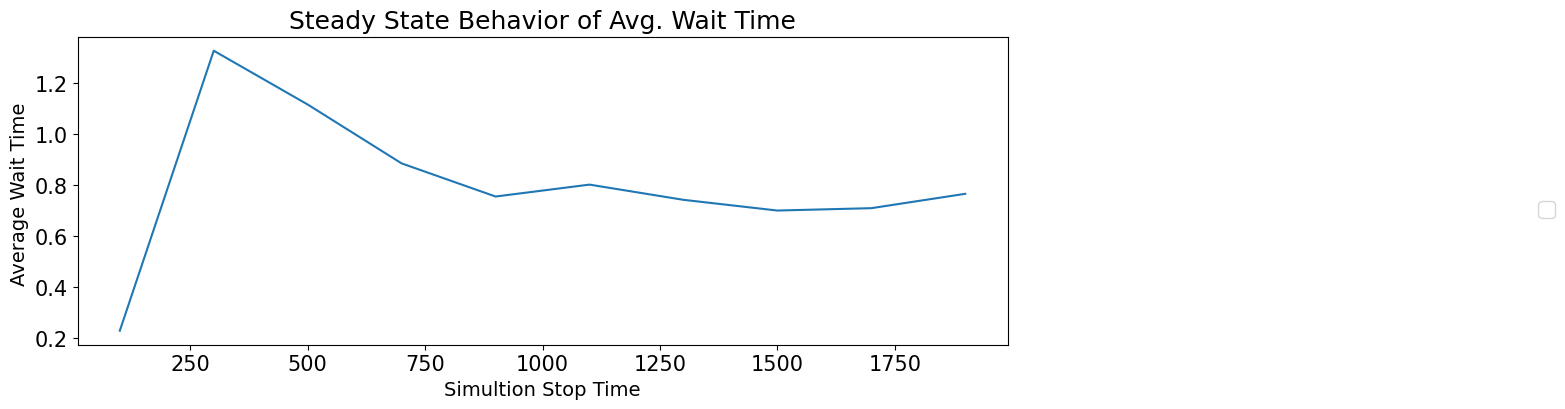

In [7]:
l = 𝜆_1 
mu = µ_1 
c = 1
begin = 100
end = 2000
increm = 200

warmup_calculation(l, mu, c, begin, end, increm)

For the City of London, the warmup time is set to be **800**, and the steady-state is set to be **800 - 2000**.

#### Warmup Calculation For M/M/1 Toronto

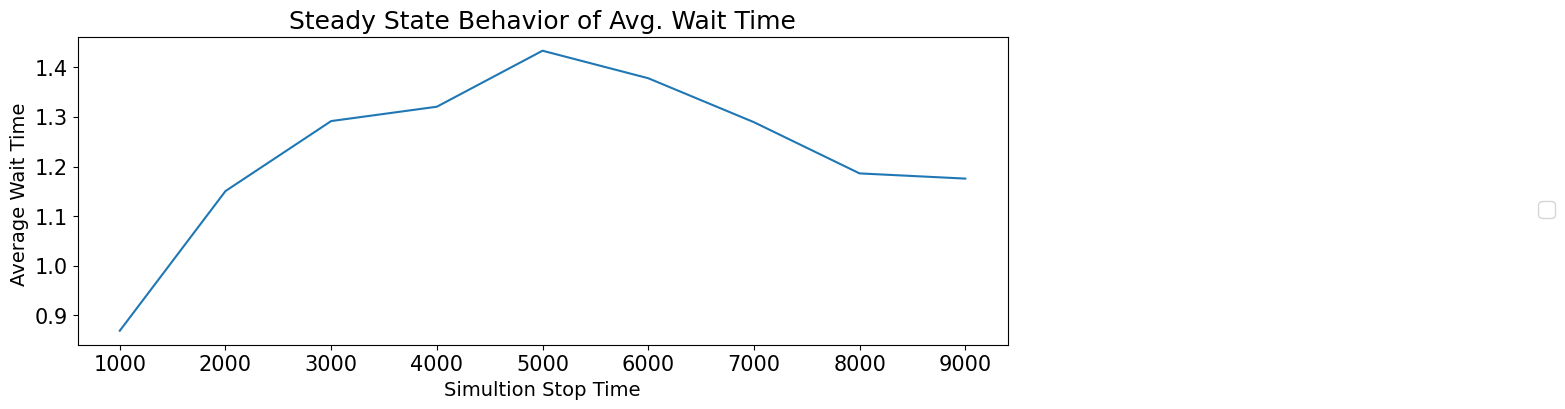

In [8]:
l = 𝜆_2 
mu = µ_2
c = 1
begin = 1000
end = 10000
increm = 1000

warmup_calculation(l, mu, c, begin, end, increm)

For the City of London, we were unable to find a suitable warmup time and maximum time. It is due to the fact that Toronto is already operating at 99.9% capacity. It becomes almost impossible to find the steady-state because the wait time will increase indefinitely as simulation time increases. Therefore, the wait time and maximum time is **set to be the same as Londo**n for observation purposes in this question.

### Simulaition for London

Simulation Output for London: 
 Utilization (c): Meand and Std  0.992 0.003 
 Expected wait time in line (Wq): Meand and Std  0.971 0.447 
 Expected time spent on the system (Ws): Meand and Std  0.98 0.447 
 Expected number of customers in line (Lq): Meand and Std  106.721 48.657 



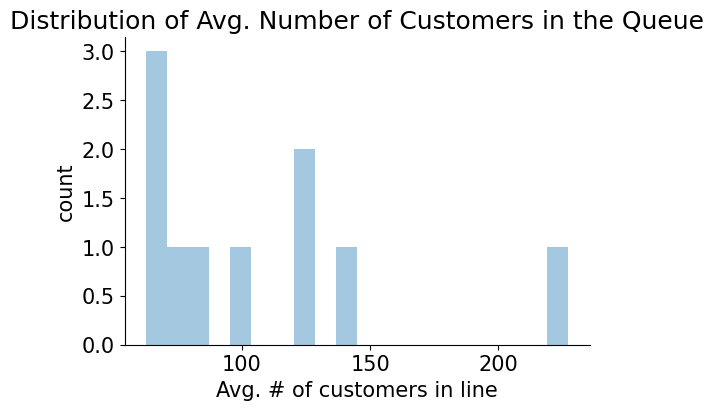

<Figure size 640x480 with 0 Axes>

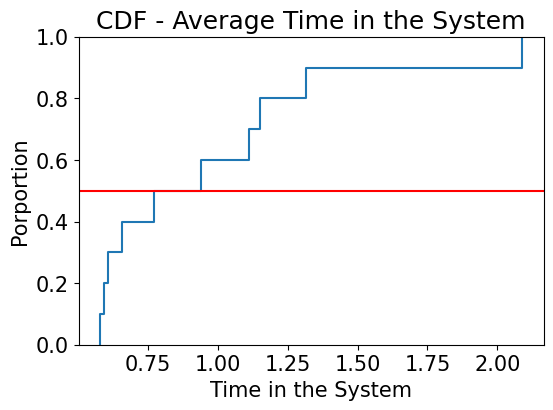

In [ ]:
l = 𝜆_1 
mu = µ_1 
c = 1
decimal = 3

max_time = 2000 
warmup = 800
cooldown = 2000
num_trials = 10

average_waits, system_time_london, num_at_queue_london, utilization = trail_wrapper(num_trials, max_time, warmup, cooldown, l = l, mu = mu, num_servers = c, decimal = decimal, location = "London" )
distribution_cdf_plot(num_at_queue_london,system_time_london)

### Simulaition for Toronto

Simulation Output for Toronto: 
 Utilization (c): Meand and Std  0.999 0.001 
 Expected wait time in line (Wq): Meand and Std  1.578 0.474 
 Expected time spent on the system (Ws): Meand and Std  1.581 0.474 
 Expected number of customers in line (Lq): Meand and Std  516.517 154.894 



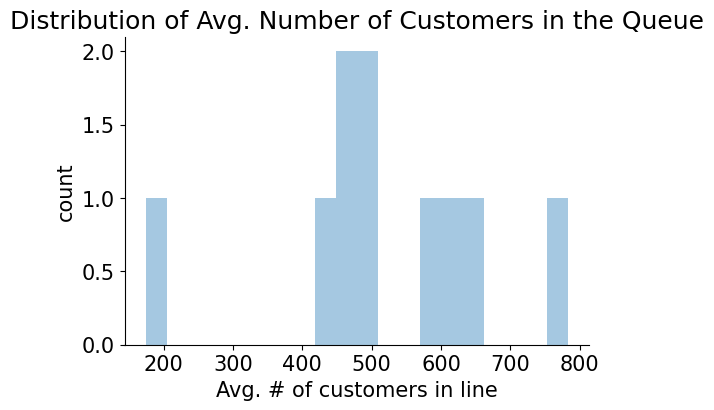

<Figure size 640x480 with 0 Axes>

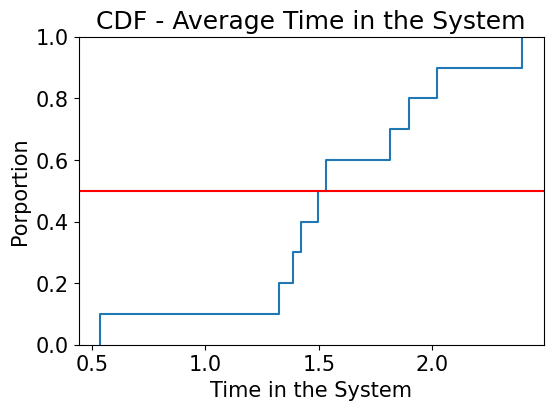

In [ ]:
l = 𝜆_2 
mu = µ_2
c = 1
decimal = 3

max_time = 2000 
warmup = 800
cooldown = max_time
num_trials = 10

average_waits, system_time_toronto, num_at_queue_toronto, utilization = trail_wrapper(num_trials, max_time, warmup, cooldown , l = l, mu = mu, num_servers = c , decimal= decimal, location = "Toronto")
distribution_cdf_plot(num_at_queue_toronto,system_time_toronto)

**Conclusion:** In the origianl scenario, the steady-state analytical outputs are:

***London***


> Utilization Rate:  0.991

> Average length of the queue:  105.687

> Average length of the system:  106.678

> Average time in queue:  0.969

> Average time in system:  0.978

***Toronto***

> Utilization Rate:  0.999

> Average length of the queue:  1282.369

> Average length of the system:  1283.369

> Average time in queue:  3.919

> Average time in system:  3.922

According to the analytical results, we found the wait time for both cities consistent with the time discussed on the case. In London, the average wait time is around 1 year, while in Toronto the wait time is almost 4 years.

After calculating the steady-state solution of the M/M/1 queue of London and Toronto, discrete simulation is applied to provide detailed insights. The warm-up period of Londo is about 750 hours, while Toronto does not arrive a steady state after 8000 hours. This suggests that the system in Toronto is not stabilizing and continues to exhibit transient behavior,which could be due to the inadequate capacity. In this case, the steady state solution might not be suitable for evaluating the queue performance.

From the simulation output, it is found that the standard deviation of expected wait time and expected length of queue is high. Also, it is found that the average number of customers in the queue in London is exponentially distributed, while it is in a bell shape in Toronto. For the average time in the system, for 50% of all the simulations, the average time in the system in London is slightly under 1 year (consistent with analytical solutoin), while in Toronto it is under 1.5 years. Also, it is noticed that there is little probability for Toronto to have average time in the system under 1 year and there is little probability for London over 1.25 years.


## Question 3


---


Keep a single wait list but reorganize the donor regions into two regions of equal capacity, effectively transforming the transplant program into an M/M/2 queue. Would any benefits result from this arrangement? discuss the solution. 

### **Steady-state Analytical Solution**

In [ ]:
𝜆_3 = (𝜆_1+𝜆_2)
µ_3 = (µ_1+µ_2)/2
c=2
𝜌,p0,lq,wq,L,W = m_m_c(𝜆_3,µ_3,c) 

print('Steady-state Analytical Solution Output for Single Waitlist, Two Regions with Equal Capacity:','\n')
print('Utilization Rate: ', round(𝜌,3))
print('Average length of the queue: ',round(lq,3))
print('Average length of the system: ', round(L,3))
print('Average time in queue: ', round(wq,3))
print('Average time in system: ', round(W,3))

Steady-state Analytical Solution Output for Single Waitlist, Two Regions with Equal Capacity: 

Utilization Rate:  0.997
Average length of the queue:  340.153
Average length of the system:  342.147
Average time in queue:  0.78
Average time in system:  0.784


**Conclusion:** 
By keeping a single waitlist and 2 regions with equal capacity, the steady state outputs are: 

> Utilization Rate:  0.997

> Average length of the queue:  340.15

> Average length of the system:  342.15

> Average time in queue:  0.78

> Average time in system:  0.784

Merging the existing two queues into an M/M/2 queue **reduces the *average time in queue* and *in system* for both areas**, while reducing the *average length of the queue* and *the system* for Toronto. However, **the new queue increases the *average length of the queue* and *system* for London**. 

Compared to having two separate queues, the *average time in queue* is reduced by 80.1% and 19.6% for Toronto and London respectively, and the *average time in system* is reduced by 80% and 20% for Toronto and London respectively. However, the new queue increases the *average length* in London by 221.8% and the *average length* of the system by 220.7%. Overall, the M/M/2 queue is effective in reducing waiting times, but has mixed effects on the average queue and system lengths.


## Question 4


---


Keep a single waitlist and one single service. Would any benefits result from this arrangement? 

### **Steady-state Analytical Solution**

In [ ]:
# M/M/1 - Toronto
𝜆_4 = (𝜆_1+𝜆_2)  #arrival rate
µ_4 = (µ_1+µ_2)    # service rate 

𝜌,p0,lq,L,wq,W = m_m_1(𝜆_4,µ_4)  
print('Steady-state Analytical Solution Output for Single Waitlist, Single Service:','\n')
print('Utilization Rate: ', round(𝜌,3))
print('Average length of the queue: ',round(lq,3))
print('Average length of the system: ', round(L,3))
print('Average time in queue: ', round(wq,3))
print('Average time in system: ', round(W,3))

Steady-state Analytical Solution Output for Single Waitlist, Single Service: 

Utilization Rate:  0.997
Average length of the queue:  340.651
Average length of the system:  341.648
Average time in queue:  0.781
Average time in system:  0.783


**Conclusion:** By keeping a single waitlist and a combined service, the steady state outputs are:

> Utilization Rate:  0.997

> Average length of the queue:  340.651

> Average length of the system:  341.648

> Average time in queue:  0.781

> Average time in system:  0.783

The M/M/1 queue with a single waitlist and one service **benefits Toronto in all aspects, reducing the average length and time in both the queue and system**. However, **for London, while the average time in the queue and system is reduced, the average length of both the queue and system increases by 220%**. In comparison to the M/M/2 queue in question 3, the M/M/1 queue shows a similar performance. Overall, these two systems yield much better performances than the current queueing system, which reflects the benefit from having a single pooling waitlist.




## Question 5


---
What would be the effect of splitting the system into two equal-sized M/M/1 queues?

### **Steady-state Analytical Solution**

In [ ]:
# M/M/1 - equal-sized
𝜆_5 = (𝜆_1+𝜆_2)/2  #arrival rate
µ_5 = (µ_1+µ_2)/2    # service rate 

𝜌,p0,lq,L,wq,W = m_m_1(𝜆_5,µ_5)  
print('Steady-state Analytical Solution Output for Equally-Splitted Waitlist and Service:','\n')
print('Utilization Rate: ', round(𝜌,3))
print('Average length of the queue: ',round(lq,3))
print('Average length of the system: ', round(L,3))
print('Average time in queue: ', round(wq,3))
print('Average time in system: ', round(W,3))

Steady-state Analytical Solution Output for Equally-Splitted Waitlist and Service: 

Utilization Rate:  0.997
Average length of the queue:  340.651
Average length of the system:  341.648
Average time in queue:  1.562
Average time in system:  1.566


**Conclusion:** By keeping 2 equal-sized waitlist and service, the steady state outputs are:


> Utilization Rate:  0.997

> Average length of the queue:  340.651

> Average length of the system:  341.648

> Average time in queue:  1.562

> Average time in system:  1.566

After splitting the system into two equal-sized M/M/1 queues, Toronto still outperforms London, **but the reduction in average time in queue and in system (60%) is less impressive than with the M/M/2 and M/M/1 systems (80%)**. Meanwhile, London performs worse across all measures. Like the previous two systems, the new setup sees a significant increase in the average length of the queue and system. However, London also experiences a 60% increase in both the average time in queue and in system, compared to the current system.




## Question 6


---
What would happen to the original waitlist (wait time in queue) if the number of donors increased from 0 to 5%? (Assess the effects on Toronto, London, and the combined M/M/1 system individually and make a comparison of the outcomes.)

### **Steady-state Analytical Solution**

In [ ]:
# M/M/1 - London
µ_6_london = µ_1*1.05
𝜆_6_london = 𝜆_1  #arrival rate


𝜌,p0,lq,L,wq,W = m_m_1(𝜆_6_london,µ_6_london)  
print('Steady-state Analytical Solution Output for Increased Donors in London:','\n')
print('Utilization Rate: ', round(𝜌,3))
print('Average length of the queue: ',round(lq,3))
print('Average length of the system: ', round(L,3))
print('Average time in queue: ', round(wq,3))
print('Average time in system: ', round(W,3))

Utilization Rate:  0.944
Average length of the queue:  15.767
Average length of the system:  16.71
Average time in queue:  0.145
Average time in system:  0.153


In [ ]:
# M/M/1 - Toronto
µ_6_tor = µ_2*1.05
𝜆_6_tor = 𝜆_2  #arrival rate


𝜌,p0,lq,L,wq,W = m_m_1(𝜆_6_tor,µ_6_tor)  
print('Steady-state Analytical Solution Output for Increased Donors in Toronto:','\n')
print('Utilization Rate: ', round(𝜌,3))
print('Average length of the queue: ',round(lq,3))
print('Average length of the system: ', round(L,3))
print('Average time in queue: ', round(wq,3))
print('Average time in system: ', round(W,3))

Utilization Rate:  0.952
Average length of the queue:  18.726
Average length of the system:  19.678
Average time in queue:  0.057
Average time in system:  0.06


In [ ]:
# Combined M/M/1 with one waitlist and one server

# total arrival rate
𝜆_total = 𝜆_1 + 𝜆_2 

# average service rate
µ_total = (µ_1 + µ_2)*1.05

# number of servers
c = 1

# run the M/M/2 model
𝜌,p0,lq,wq,L,W = m_m_c(𝜆_total,µ_total,c)
print('Utilization Rate: ', round(𝜌,2))
print('Average length of the queue: ',round(lq,2))
print('Average length of the system: ', round(L,2))
print('Avg. Time in queue:{}'.format(round(wq,3)))
print('Avg. Time in system:{}'.format(round(W,3)))


Utilization Rate:  0.95
Average length of the queue:  17.89
Average length of the system:  18.84
Avg. Time in queue:0.041
Avg. Time in system:0.043


In [ ]:
# Combined M/M/1 with two equal sized queues

# total arrival rate
𝜆_avg = (𝜆_1 + 𝜆_2)/2

# average service rate
µ_avg = (µ_1 + µ_2)*1.05/2

# number of servers
c = 1

# run the M/M/1 model
𝜌,p0,lq,wq,L,W = m_m_c(𝜆_avg,µ_avg,c)
print('Utilization Rate: ', round(𝜌,2))
print('Average length of the queue: ',round(lq,2))
print('Average length of the system: ', round(L,2))
print('Avg. Time in queue:{}'.format(round(wq,3)))
print('Avg. Time in system:{}'.format(round(W,3)))

Utilization Rate:  0.95
Average length of the queue:  17.89
Average length of the system:  18.84
Avg. Time in queue:0.082
Avg. Time in system:0.086


The results and explanations for each scenario are discussed below:

***London M/M/1 system:***
Assuming that the arrival rate (λ) remains constant, increasing the service rate (μ) by increasing the number of available kidney transplant donors from 0 to 5% will decrease the average time a customer spends waiting in the queue (Lq) and the average time a customer spends in the system (W). According to the Steady-state Analytical Solution, the new average time in queue significantly improves to 0.145 years, and the new average total time in the system improves to 0.153 years.

***Toronto M/M/1 system:***
Similarly, assuming that the arrival rate and service rate are constant, increasing the number of donors from 0 to 5% will decrease the average time a customer spends waiting in the queue (Lq) and the average time a customer spends in the system (W). According to the Steady-state Analytical Solution, the new average time in queue significantly improves to 0.057 years, and the new average total time in the system improves to 0.06 years.

***Combined M/M/1 system:***
When combining the two cities' M/M/1 systems, the same principles apply. The combined M/M/1 system will see a greater decrease in wait time compared to the individual cities' systems because there are now more donors available to both cities, increasing the likelihood of finding a match and reducing the need for patients to wait for a match. According to the Steady-state Analytical Solution, the new average time in queue significantly improves to 0.041 years, and the new average total time in the system improves to 0.043 years. The improvement in wait time is greater in the combined M/M/1 system compared to the individual cities' systems due to the increased pool of potential donors. 


***Two M/M/1 systems with equal-sized waitlist and service:***
When having 2 equal-sized M/M/1 systems, the new average time in queue is 0.082 years, and the new average total time in the system is 0.086 years. The improvement in wait time is not as great as the combined system discussed above due to the fact that seperate servers do not benefit from increased pool of donors. 

Therefore, it can be concluded that:

*   More donors would substantially improve wait time
*   Pooling potential donors in both regions into one waitlist improves the overall waittime 




## Question 7
What would happen to the original waitlist (wait time in queue) if the arrival of patients increased from 0 to 5%? (Assess the effects on Toronto, London, and the combined  system individually and make a comparison of the outcomes.)

### **Steady-state Analytical Solution**

In [14]:
# Toronto

# service rate - Toronto
µ_7 = µ_2

# arrival rate - Toronto
𝜆_7 = 𝜆_2*1.05

𝜌_2,p0_2,lq_2,L_2,wq_2,W_2 = m_m_1(𝜆_7,µ_7)

print('Utilization Rate: ', round(𝜌_2,2))
print('Average length of the queue: ',round(lq_2,2))
print('Average length of the system: ', round(L_2,2))
print('Average time in queue: ', round(wq_2,2))
print('Average time in system: ', round(W_2,2))

Utilization Rate:  1.05
Average length of the queue:  -22.38
Average length of the system:  -21.33
Average time in queue:  -0.07
Average time in system:  -0.06


In [15]:
# London

# service rate - Toronto
µ_7_london = µ_1

# arrival rate - Toronto
𝜆_7_london = 𝜆_1*1.05

𝜌_2,p0_2,lq_2,L_2,wq_2,W_2 = m_m_1(𝜆_7_london,µ_7_london)

print('Utilization Rate: ', round(𝜌_2,2))
print('Average length of the queue: ',round(lq_2,2))
print('Average length of the system: ', round(L_2,2))
print('Average time in queue: ', round(wq_2,2))
print('Average time in system: ', round(W_2,2))

Utilization Rate:  1.04
Average length of the queue:  -26.89
Average length of the system:  -25.85
Average time in queue:  -0.23
Average time in system:  -0.23


In [16]:
# Combined System M/M/1

# service rate - Toronto
µ_7_combine = µ_1 + µ_2

# arrival rate - Toronto
𝜆_7_combine = 𝜆_1*1.05 + 𝜆_2*1.05

𝜌_2,p0_2,lq_2,L_2,wq_2,W_2 = m_m_1(𝜆_7_combine,µ_7_combine)

print('Utilization Rate: ', round(𝜌_2,2))
print('Average length of the queue: ',round(lq_2,2))
print('Average length of the system: ', round(L_2,2))
print('Average time in queue: ', round(wq_2,2))
print('Average time in system: ', round(W_2,2))

Utilization Rate:  1.05
Average length of the queue:  -23.35
Average length of the system:  -22.31
Average time in queue:  -0.05
Average time in system:  -0.05


**The analytical approach is not applicable:** If the arrival of patients increased from 0 to 5%, the utilization rate is over 1 in Toronto, London, and the combined systems. If the utilization rate (ρ) is greater than 1 (i.e., over 100%), it means that the arrival rate is greater than the combined service rate of all servers, and the system is considered unstable. In this case, the queue will grow indefinitely as customers arrive faster than they can be served. This leads to ever-increasing waiting times, queue lengths, and poor system performance. Therefore, the results of the average length of the queue, the average length of the system, the average time in the queue, and the average time in the system are all negative in all cases. Therefore, we utilized the simulation method. 


### **Discrete Simulation**

### London

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


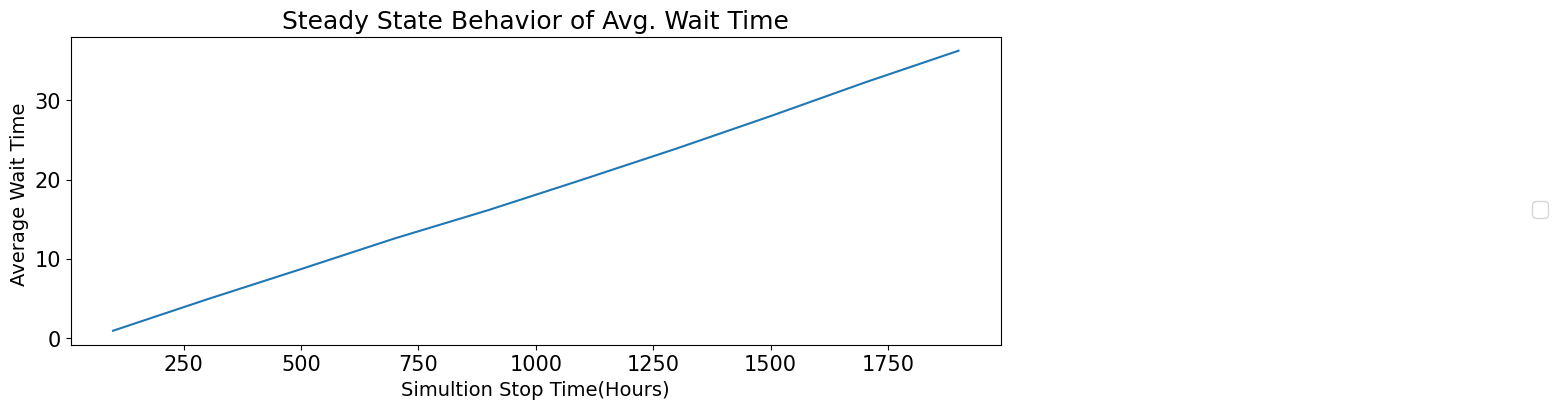

In [ ]:
l7_london = 𝜆_1 * 1.05
mu7_london =µ_1 
c7 = 1

begin = 100
end = 2000
increm = 200

warmup_calculation(l7_london, mu7_london, c7, begin, end, increm)

Simulation Output for London: 
 Utilization (c): Meand and Std  0.945 0.004 
 Expected wait time in line (Wq): Meand and Std  0.152 0.016 
 Expected time spent on the system (Ws): Meand and Std  0.161 0.016 
 Expected number of customers in line (Lq): Meand and Std  17.537 1.751 



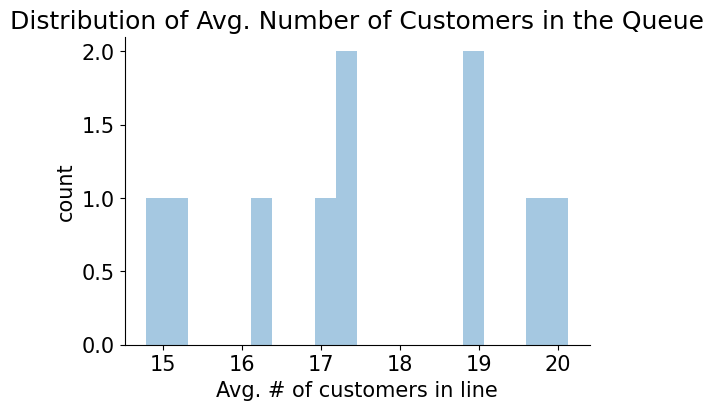

<Figure size 640x480 with 0 Axes>

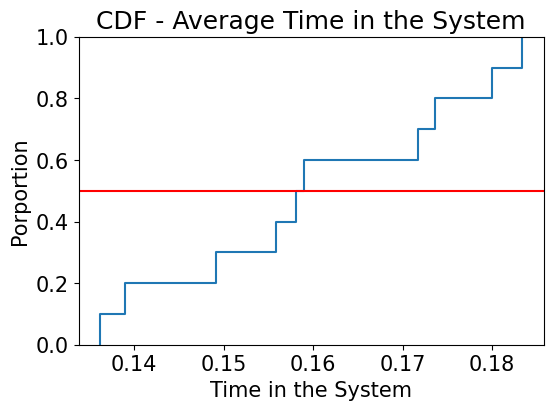

In [ ]:
l7_london = 𝜆_1 * 1.05
mu7_london =µ_1 
c7 = 1
decimal = 3

max_time = 1000 
warmup = 0
cooldown = max_time
num_trials = 10 

average_waits, system_time_6_lon, num_at_queue_6_lon, utilization = trail_wrapper(num_trials, max_time, warmup, cooldown , l = l7_london, mu = mu7_london, num_servers = c7, decimal= decimal, location = "London")
distribution_cdf_plot(num_at_queue_6_lon,system_time_6_lon)

### Toronto

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


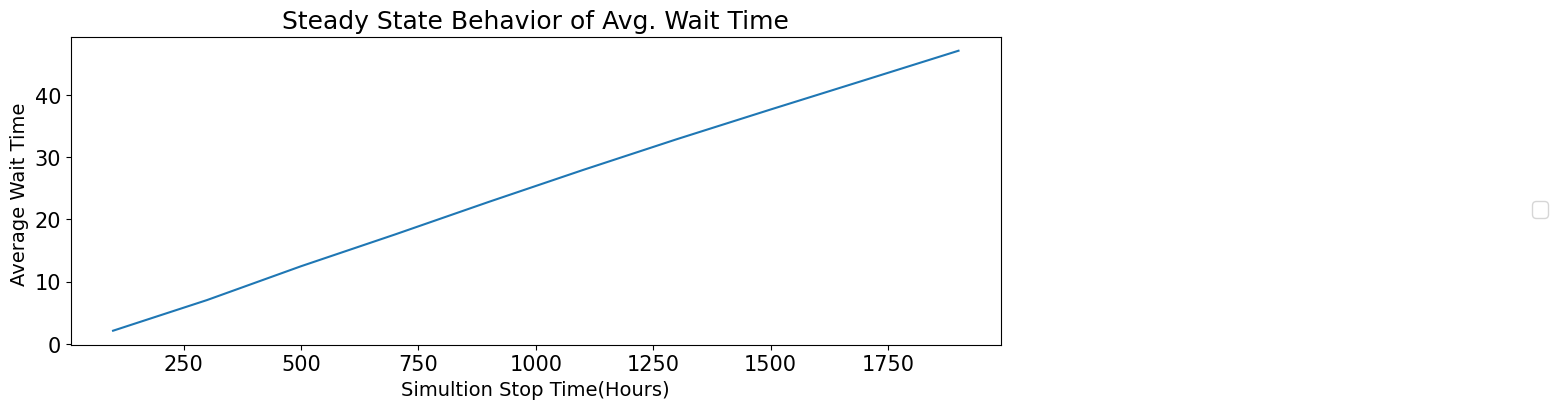

In [ ]:
l7_tor = 𝜆_2 *1.05
mu7_tor =µ_2
c7 = 1

begin = 100
end = 2000
increm = 200

warmup_calculation(l7_tor, mu7_tor, c7, begin, end, increm)

### Combined M/M/1 with one waitlist and one server

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


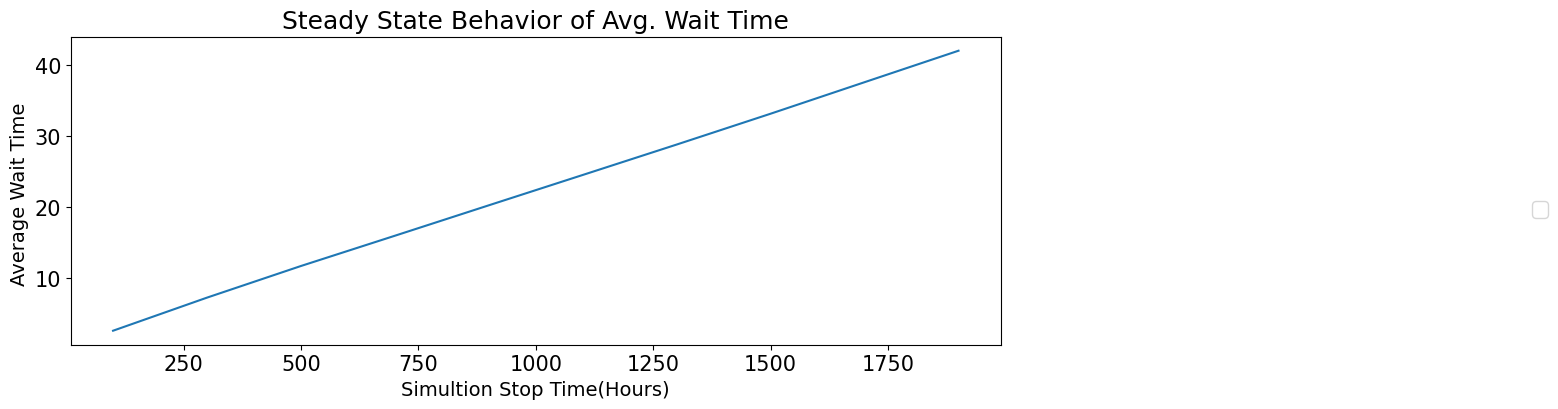

In [ ]:
𝜆_total = (𝜆_1 + 𝜆_2) * 1.05
µ_total = (µ_1 + µ_2)
c = 1

begin = 100
end = 2000
increm = 200

warmup_calculation(𝜆_total, µ_total, c, begin, end, increm)

In [ ]:
𝜆_total = (𝜆_1 + 𝜆_2)*1.05
µ_total = µ_1 + µ_2
c = 1
decimal = 3

max_time = 2000 
warmup = 800
cooldown = 2000
num_trials = 100 

average_waits, system_time_6_c1, num_at_queue_6_c1, utilization = trail_wrapper(num_trials, max_time, warmup, cooldown , l = 𝜆_total, mu = µ_total, num_servers = c, decimal= decimal, location = "Combined (one waitlist + one server)")
distribution_cdf_plot(num_at_queue_6_c1,system_time_6_c1)

### Combined M/M/1 with two equal sized queues

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


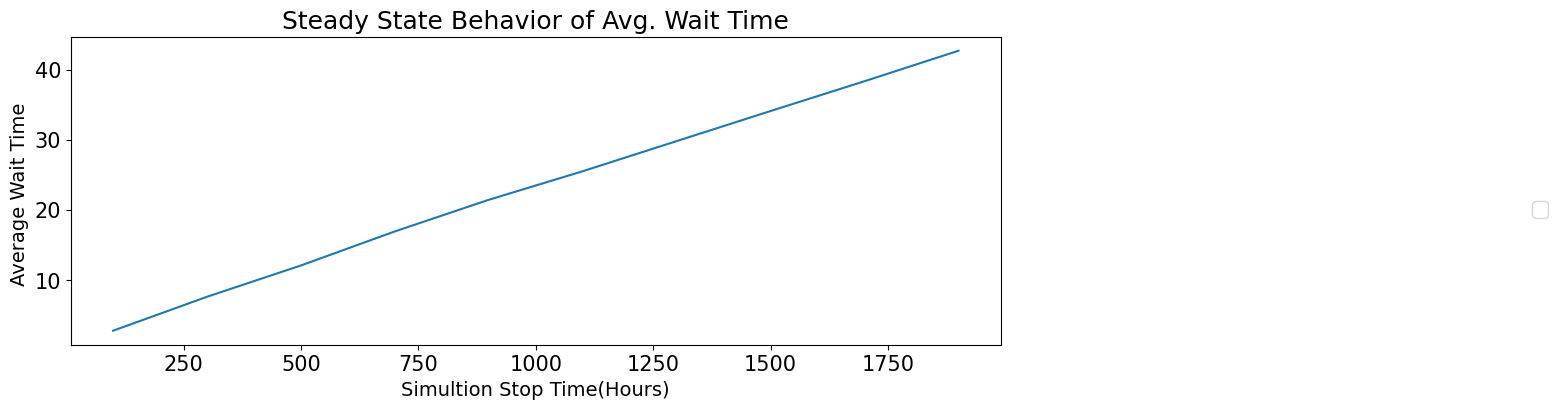

In [ ]:
𝜆_avg = (𝜆_1 + 𝜆_2) /2*1.05
µ_avg = (µ_1 + µ_2)/2
c = 1

begin = 100
end = 2000
increm = 200

warmup_calculation(𝜆_avg, µ_avg, c, begin, end, increm)

In [ ]:
𝜆_avg = (𝜆_1 + 𝜆_2) /2*1.05
µ_avg = (µ_1 + µ_2)/2
c = 1
decimal = 3

max_time = 2000 
warmup = 800
cooldown = 2000
num_trials = 100 

average_waits, system_time_6_c2, num_at_queue_6_c2, utilization = trail_wrapper(num_trials, max_time, warmup, cooldown , l = 𝜆_avg, mu = µ_avg, num_servers = c, decimal= decimal, location = "Toronto")
distribution_cdf_plot(num_at_queue_6_c2,system_time_6_c2)

**Conclusion:** Since analytical approach is not applicable, the simulation method is selected for further analysis. However in simulation approach, we try to find a steady state by running the simulation for a long enough time and discarding an initial "warm-up" period to avoid the impact of the initial transient state on the results. However, when the system is unstable, there is no steady state to be reached, making it difficult to identify an appropriate simulation length and warm-up time. 

The indefinite increase in wait time is caused by the fact that a 5% increase in arrival rate **makes the system exceed its service capacity**. Originally, both London and Toronto was already operating at its 99% capacity. Thus, the increase in arrival rate destroys the current system，causing increasing long waiting time for future patients。


## Question 8
What would happen if the system has more variation (i.e. CV) than expected in the arrival process? What would you do in this situation? (Assess the effects on Toronto, London, and the combined M/M/1 system individually and make a comparison of the outcomes.)

In [ ]:
# Toronto

s2 = 1/µ_2 # service time 
cv_s2 = 1 # coefficient of variation - service time

a2 = 1/𝜆_2 # inter-arrivial time
cv_a2 = 1.5 # coefficient of variation - inter-arrival time

c = 1

𝜌,lq,wq,L,W = g_g_c(s2,cv_s2,a2,cv_a2,c)
print('Utilization Rate: ', round(𝜌,3))
print('Average length of the queue: ',round(lq,3))
print('Average length of the system: ', round(L,3))
print('Avg. Time in queue:{}'.format(round(wq,3)))
print('Avg. Time in system:{}'.format(round(W,3)))


Utilization Rate:  0.999
Average length of the queue:  2085.474
Average length of the system:  2086.474
Avg. Time in queue:6.368
Avg. Time in system:6.371


In [ ]:
# London

s1 = 1/µ_1 # service time 
cv_s1 = 1 # coefficient of variation - service time

a1 = 1/𝜆_1 # inter-arrivial time
cv_a1 = 1.5 # coefficient of variation - inter-arrival time

c = 1

𝜌,lq,wq,L,W = g_g_c(s1,cv_s1,a1,cv_a1,c)
print('Utilization Rate: ', round(𝜌,3))
print('Average length of the queue: ',round(lq,3))
print('Average length of the system: ', round(L,3))
print('Avg. Time in queue:{}'.format(round(wq,3)))
print('Avg. Time in system:{}'.format(round(W,3)))


Utilization Rate:  0.991
Average length of the queue:  173.352
Average length of the system:  174.352
Avg. Time in queue:1.575
Avg. Time in system:1.584


In [ ]:
# Combined M/M/1 with one waitlist and one server

µ_total = µ_1 + µ_2 # service rate 
s_total = 1/µ_total # service time 
cv_s_total = 1 # coefficient of variation - service time

𝜆_total = 𝜆_1 + 𝜆_2 # arrival rate 
a_total = 1/𝜆_total # inter-arrivial time
cv_a_total = 1.5 # coefficient of variation - inter-arrival time

c = 1

𝜌,lq,wq,L,W = g_g_c(s_total,cv_s_total,a_total,cv_a_total,c)
print('Utilization Rate: ', round(𝜌,3))
print('Average length of the queue: ',round(lq,3))
print('Average length of the system: ', round(L,3))
print('Avg. Time in queue:{}'.format(round(wq,3)))
print('Avg. Time in system:{}'.format(round(W,3)))


Utilization Rate:  0.997
Average length of the queue:  555.177
Average length of the system:  556.177
Avg. Time in queue:1.269
Avg. Time in system:1.271


In [ ]:
# Combined M/M/1 with two equal sized queues

µ_avg = (µ_1 + µ_2)/2 # service rate 
s_avg = 1/µ_avg # service time 
cv_s_avg = 1 # coefficient of variation - service time

𝜆_avg = (𝜆_1 + 𝜆_2)/2 # arrival rate 
a_avg = 1/𝜆_avg # inter-arrivial time
cv_a_avg = 1.5 # coefficient of variation - inter-arrival time

c = 1

𝜌,lq,wq,L,W = g_g_c(s_avg,cv_s_avg,a_avg,cv_a_avg,c)
print('Utilization Rate: ', round(𝜌,3))
print('Average length of the queue: ',round(lq,3))
print('Average length of the system: ', round(L,3))
print('Avg. Time in queue:{}'.format(round(wq,3)))
print('Avg. Time in system:{}'.format(round(W,3)))

Utilization Rate:  0.997
Average length of the queue:  555.177
Average length of the system:  556.177
Avg. Time in queue:2.538
Avg. Time in system:2.542


**Conclusion:** Suppose the system has more variation (i.e. CV) than expected in the arrival process. In that case, the original M/M/c model is no longer applicable since the M/M/c model assumes exponential distributions for interarrival and service times, which have a CV of 1. Therefore, **we could apply a more general queueing G/G/c model**.

Specifically, we increased CV from 1 to 1.5 and applied G/G/c model to see the changes. For Toronto, since the arrival variation rose, the queue and system length almost doubled, and the average time in queue increased to more than 6 years compared to the original around four years. For London, since the arrival variation rose, the queue and system length almost doubled, and the average time in queue increased to more than 1.5 years compared to the original around 1 years. The wait times in queue and system are also significantly higher in the combined models. 

This is intuitively correct since the original system already has a very high utilization rate, close to 1. **A slight increase in the number of arrivals would crush the system.** The increases in all metrics appear for all other systems: “London,” “combined waitlist, combined service,” and “two waitlists, two equal-sized services” as shown in the output table from the Excel sheet. 


## Question 9


---

What specific recommendations would you make to improve the system?

To summarize all the scenarios, the chart below shows the detailed performance for each model:
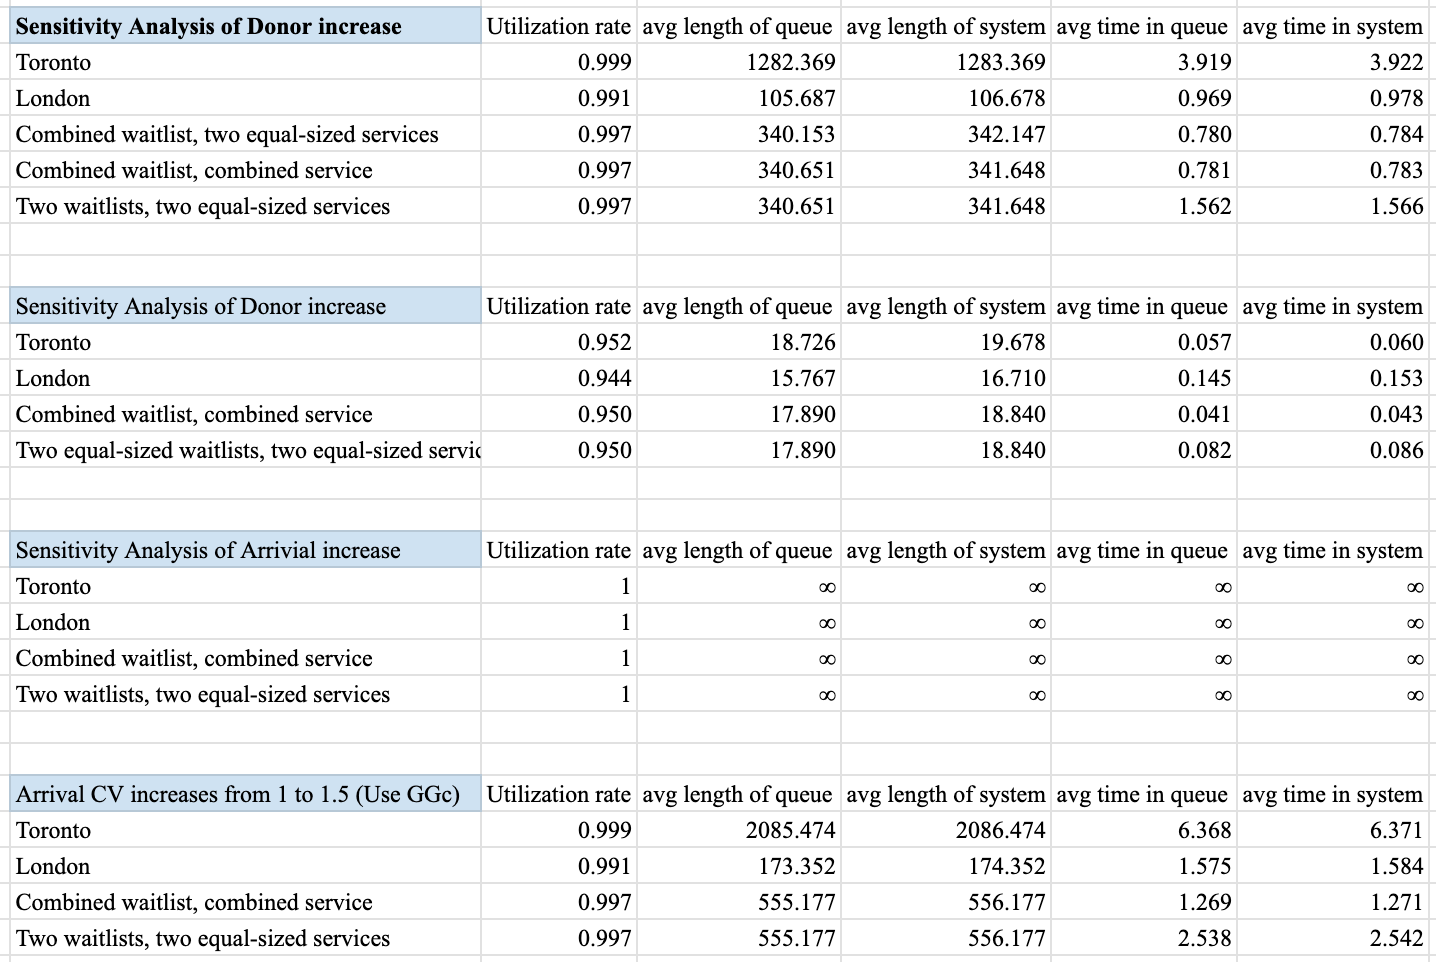

**1. Pooling two waitlists together**

> As discussed in question 3,4 and 5, From all the queueing systems we have experimented with, we see that pooling the two waitlists together results in a much better performance as the average time in the queue and in the system are reduced by a considerable amount, and so does the overall average length in the queue and the system. Hence, it is better to keep a single waitlist to yield better queue performance.


**2. Improve service rate in response to arrival rate fluctuations**

> As discussed in question 7 and question 8, given that the utilization rate is already close to 1, even a slight increase in the number of patients could overwhelm the system, resulting in longer waiting times and queue lengths. Under the condition of increasing the arrival rate of patients, it's essential to increase the service rate accordingly. One possible method is to accelerate the proccess of kidney transplant from living donors (i.e. patient’s family members).

**3. Launch campaigns to boost organ donations**


> According to the result in question 6, it can be found that a small increase in the number of donors can substantailly improve the current queueing system with sigfinicantly less waiting time. Therefore, one possible solution is to launch campaigns to raise public awareness for organ donation and increase the number of donors in the future.




## Appendix: Simulation Analysis for Q3, Q4 and Q5

### Question 3 Discrete Simulation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


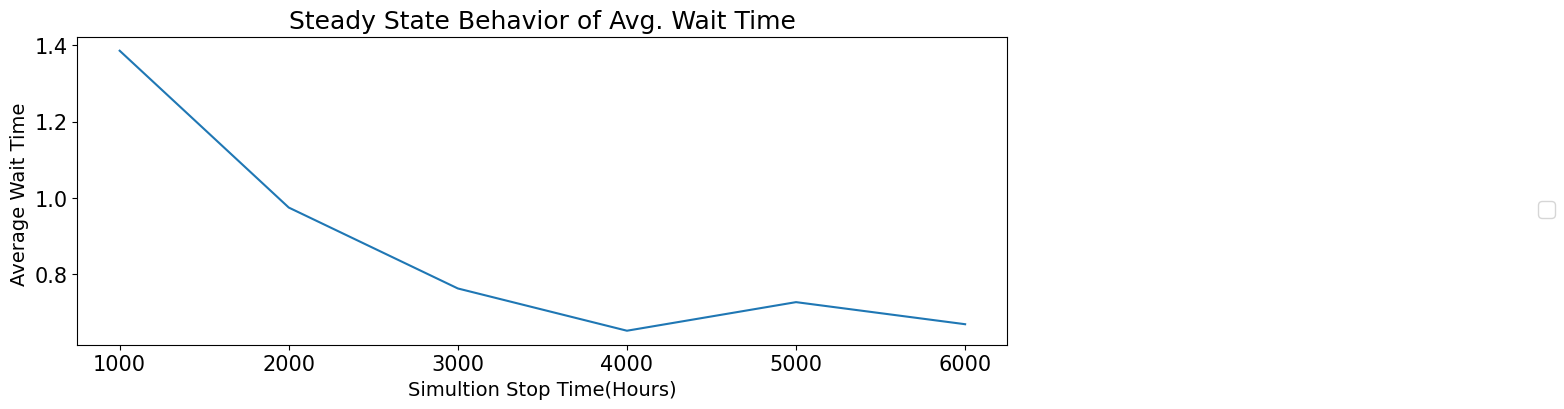

In [ ]:
𝜆_3 = (𝜆_1+𝜆_2)
µ_3 = (µ_1+µ_2)/2
c_3 = 2
begin = 1000
end = 7000
increm = 1000

warmup_calculation(𝜆_3, µ_3, c, begin, end, increm)

Simulation Output for Question 3: 
 Utilization (c): Meand and Std  0.996 0.002 
 Expected wait time in line (Wq): Meand and Std  0.685 0.273 
 Expected time spent on the system (Ws): Meand and Std  0.69 0.273 
 Expected number of customers in line (Lq): Meand and Std  300.904 119.398 



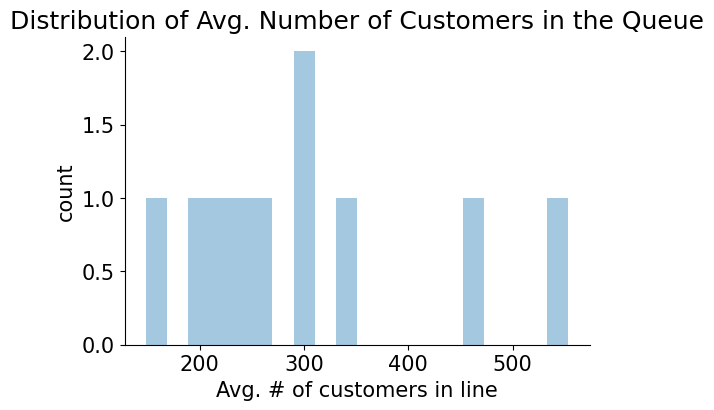

<Figure size 640x480 with 0 Axes>

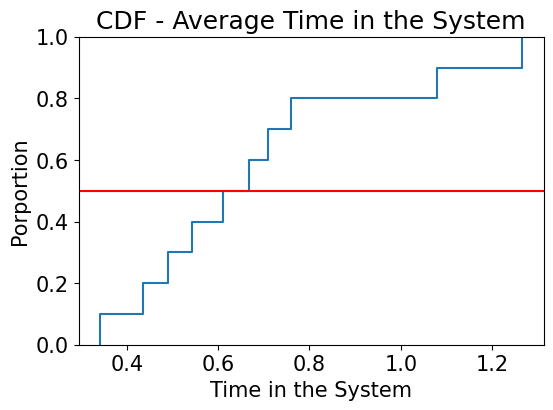

In [ ]:
l3 = 𝜆_1 + 𝜆_2
mu3 = (µ_1 + µ_2) / 2
c3 = 2
decimal = 3

max_time = 6000
warmup = 4000
cooldown = max_time
num_trials = 10

average_waits, system_time_3, num_at_queue_3, utilization = trail_wrapper(num_trials, max_time, warmup, cooldown , l = l3, mu = mu3, num_servers = c3 , decimal= decimal, location = "Question 3")
distribution_cdf_plot(num_at_queue_3,system_time_3)

### Question 4 Discrete Simulation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


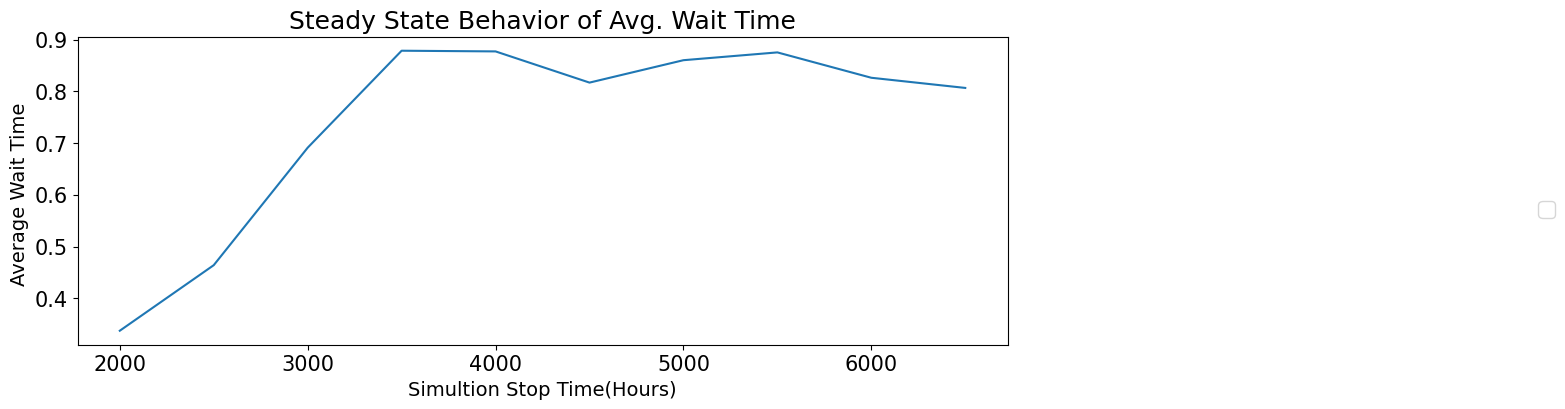

In [ ]:
l4 = 𝜆_1 + 𝜆_2
mu4 = µ_1 + µ_2
c4 = 1
begin = 2000
end = 7000
increm = 500

warmup_calculation(l4, mu4, c4, begin, end, increm)

Simulation Output for Question 4: 
 Utilization (c): Meand and Std  0.998 0.002 
 Expected wait time in line (Wq): Meand and Std  0.955 0.529 
 Expected time spent on the system (Ws): Meand and Std  0.957 0.529 
 Expected number of customers in line (Lq): Meand and Std  418.084 231.267 



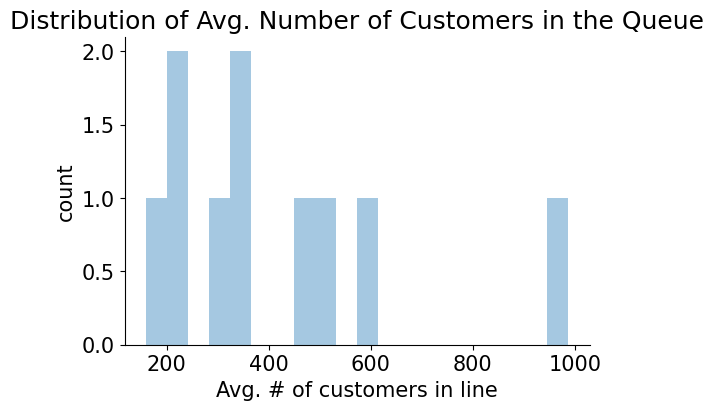

<Figure size 640x480 with 0 Axes>

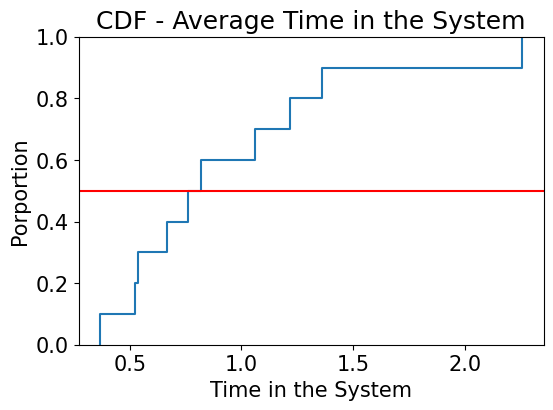

In [ ]:
l4 = 𝜆_1 + 𝜆_2
mu4 = µ_1 + µ_2
c4 = 1
decimal = 3

max_time = 5000 
warmup = 3500
cooldown = max_time
num_trials = 10

average_waits, system_time_4, num_at_queue_4, utilization = trail_wrapper(num_trials, max_time, warmup, cooldown , l = l4, mu = mu4, num_servers = c4, decimal= decimal, location = "Question 4")
distribution_cdf_plot(num_at_queue_4,system_time_4)

### Question 5 Discrete Simulation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


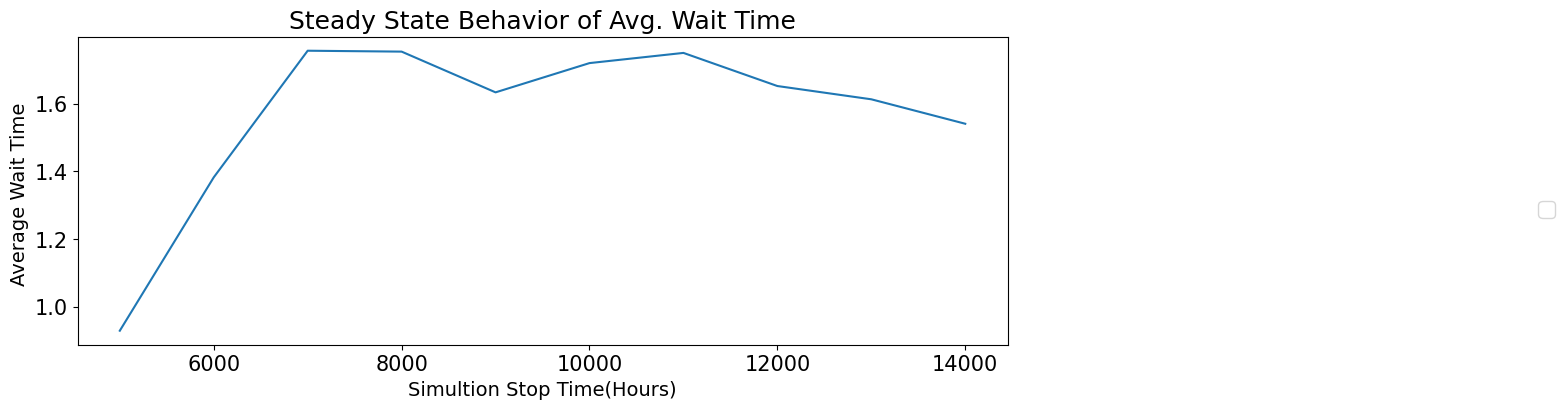

In [ ]:
𝜆_5 = (𝜆_1+𝜆_2)/2  #arrival rate
µ_5 = (µ_1+µ_2)/2 
c = 1
begin = 5000
end = 15000
increm = 1000

warmup_calculation(𝜆_5, µ_5, c, begin, end, increm)

Simulation Output for Question 5: 
 Utilization (c): Meand and Std  0.997 0.002 
 Expected wait time in line (Wq): Meand and Std  1.67 1.012 
 Expected time spent on the system (Ws): Meand and Std  1.675 1.012 
 Expected number of customers in line (Lq): Meand and Std  364.946 220.682 



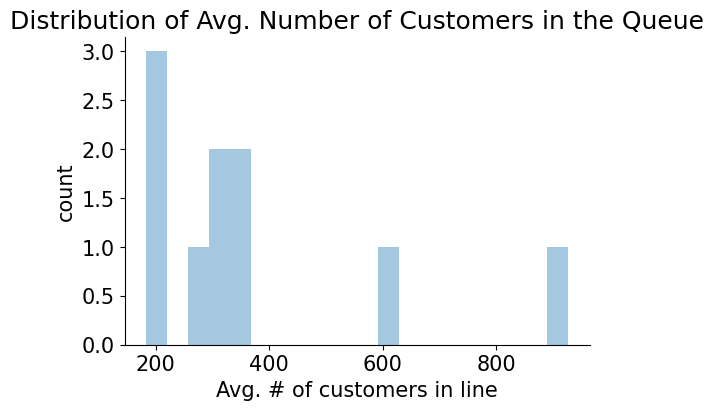

<Figure size 640x480 with 0 Axes>

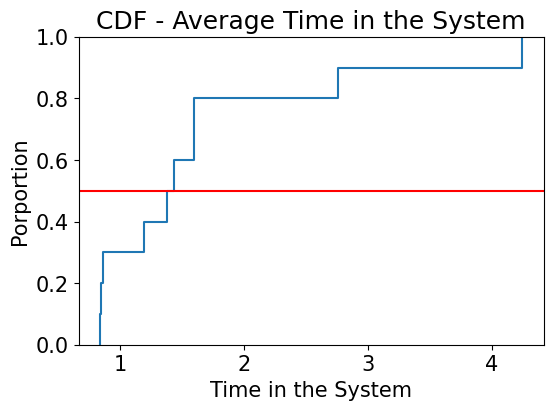

In [ ]:
l5 = (𝜆_1+𝜆_2)/2
mu5 = (µ_1+µ_2)/2 
c5 = 1
decimal = 3

max_time = 5000 
warmup = 3500
cooldown = max_time
num_trials = 10

average_waits, system_time_4, num_at_queue_4, utilization = trail_wrapper(num_trials, max_time, warmup, cooldown , l = l5, mu = mu5, num_servers = c5, decimal= decimal, location = "Question 5")
distribution_cdf_plot(num_at_queue_4,system_time_4)